In [1]:
import torch
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionInpaintPipeline
from diffusers import utils
from diffusers import UNet2DConditionModel
from diffusers import AudioLDMPipeline

from torchvision.utils import save_image
import csv
import IPython.display as ipd

import matplotlib.pyplot as plt
import PIL
import torch
from io import BytesIO
from torchvision.utils import save_image
from tqdm import tqdm
import skimage
import numpy as np
from scipy.io.wavfile import write
import argparse, os, sys, datetime, glob, importlib, csv
import numpy as np
import torch
import torchvision

from PIL import Image

sys.path.append(os.getcwd())
# import cv2
import torchaudio
import torchaudio.transforms as transforms
import time
from encodec import EncodecModel
from encodec.utils import convert_audio
import torch.nn.functional as F
from transformers import AutoTokenizer, T5EncoderModel

%matplotlib inline

In [2]:
def show_split_img(image, title=None):
    # Split the image in half horizontally
    height, width = image.shape
    half_width = width // 2
    left_half = image[:, :half_width]
    right_half = image[:, half_width:]

    # Create the subplots and plot the left and right halves of the image
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 2))
    axs[0].imshow(left_half)
    axs[1].imshow(right_half)

    # Hide the x and y axis ticks and labels for a cleaner plot
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Show the plot
    # if (title):
    #     axs[0].title(title)
    plt.show()


In [4]:
model_path = "/u/li19/data_folder/model_cache/audio_journey"
device = "cuda:4"
# model_path = "CompVis/stable-diffusion-v1-4"




In [5]:
pipe = StableDiffusionPipeline.from_pretrained(model_path, device_map=None, safety_checker=None)
pipe.to(device)



/u/li19/data_folder/anaconda3/envs/diffuse/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.15.1",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [7]:

conf = "/u/li19/data_folder/testing/audio_journey_128_channel_norm/unet"

new_unet = UNet2DConditionModel.from_pretrained(conf)
new_unet.to(device)
pipe.unet = new_unet



In [8]:
model = EncodecModel.encodec_model_24khz()
model.set_target_bandwidth(6.0)
model = model.to(device)
# pipe.vae = model

In [10]:
prompts = ["a sin wave",
          # "a whip whipping",
          "a dog barking, howling, bark",
           "Speech, Singing, and Yodeling",
           # "Hammer striking metal",
           # "Brass instrument, and Saxophone"
          ]

pipe.vae_scale_factor = 1

imgs = [pipe(prompt=p, width=504, height=8, num_inference_steps=200, output_type="latent").images[0] for p in prompts]


  0%|          | 0/200 [00:00<?, ?it/s]

RuntimeError: shape '[2, 128, 24, 21]' is invalid for input of size 8064

torch.Size([1, 8, 504])


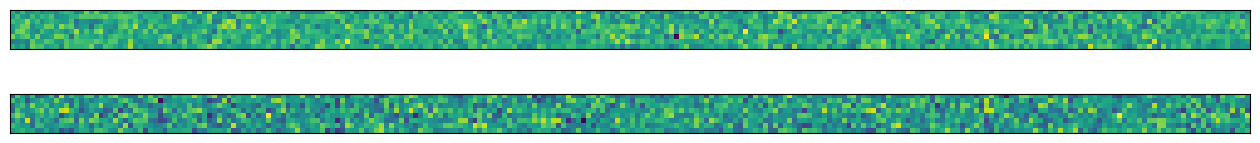

torch.Size([1, 8, 504])


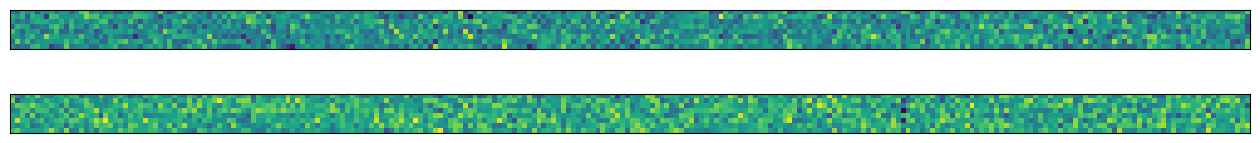

torch.Size([1, 8, 504])


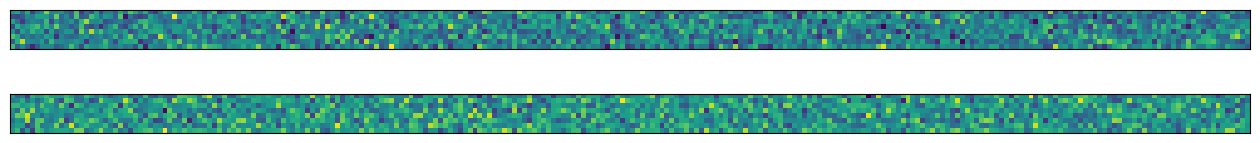

In [10]:
# print("================================MULTI PROMPT================================")
for img in imgs:
    print(img.shape)
    show_split_img(img[0,:,:].cpu())

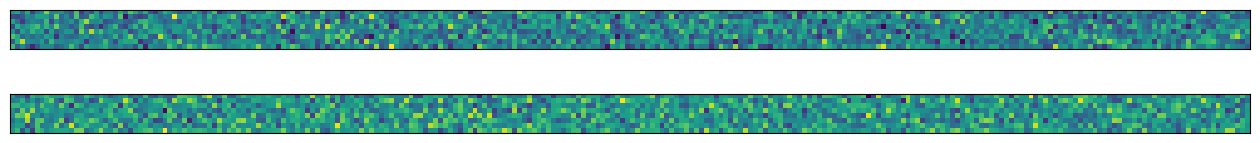

tensor(551.8374)
tensor(-544.8793)
tensor(1023.)
tensor(0.)
torch.Size([1, 8, 504])
[(tensor([[[581, 647, 425,  ..., 473, 684, 468],
         [316, 291, 356,  ..., 717, 244, 376],
         [641, 443, 259,  ..., 234, 349, 559],
         ...,
         [770, 657, 408,  ..., 286, 662, 560],
         [375, 683, 921,  ..., 714, 647, 503],
         [724, 366, 550,  ..., 463, 593, 535]]], device='cuda:0'), tensor([1], device='cuda:0'))]


In [13]:



img = np.copy(imgs[2].cpu())

img = torch.from_numpy(img[0,:,:])


show_split_img(img)

print(img.max())
print(img.min())

latent = img[None, :, :]
latent -= latent.min()
latent /= latent.max()
latent *=  1023

print(latent.max())
print(latent.min())

latent = latent.to(torch.int64)
scale = torch.tensor([1]).to(torch.int64)
print(latent.shape)
pack = [(latent.to("cuda"), scale.to("cuda"))]

print(pack)
wav = model.decode(pack)
wav = wav.cpu().detach().numpy()[0,0,:]

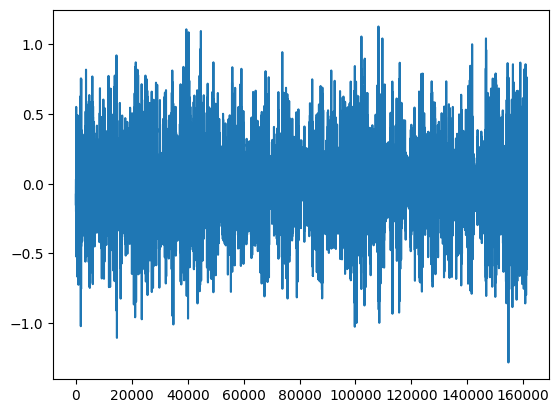

In [14]:
plt.plot(wav)
ipd.Audio(wav, rate=16000)

<class 'numpy.ndarray'>


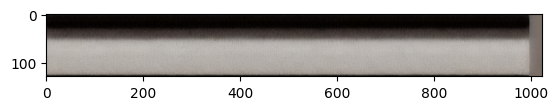

In [35]:
plt.imshow(img)
print(type(img))

tensor(0.)
tensor(0.9235)
tensor(0.4253)
tensor(0.2046)
torch.Size([1, 1024, 128])
NEW
tensor(-2.)
tensor(1.6939)
tensor(-0.2989)
tensor(0.8182)
torch.Size([1, 1024, 128])


/tmp/ipykernel_319810/2432511748.py:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.imshow(img.T)


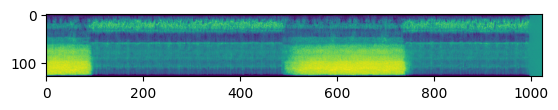

In [36]:
img = torch.tensor(imgs[0][:,:,:1].T)
print(img.min())
print(img.max())
print(img.mean())
print(img.std())
print(img.shape)

img = img * 4
img = img - 2

print("NEW")
print(img.min())
print(img.max())
print(img.mean())
print(img.std())
print(img.shape)
plt.imshow(img.T)

In [26]:
gen_recon = restore_wav(img)

inv-melspec
inv-melspec-finished
griffin_lim
griffin_lim-finished


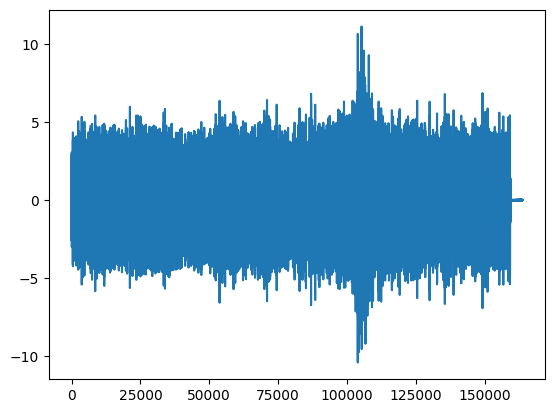

In [27]:
plt.plot(gen_recon)
ipd.Audio(gen_recon, rate=16000)

In [28]:

# Instantiate a pretrained EnCodec model
model = EncodecModel.encodec_model_24khz()
# The number of codebooks used will be determined bythe bandwidth selected.
# E.g. for a bandwidth of 6kbps, `n_q = 8` codebooks are used.
# Supported bandwidths are 1.5kbps (n_q = 2), 3 kbps (n_q = 4), 6 kbps (n_q = 8) and 12 kbps (n_q =16) and 24kbps (n_q=32).
# For the 48 kHz model, only 3, 6, 12, and 24 kbps are supported. The number
# of codebooks for each is half that of the 24 kHz model as the frame rate is twice as much.
model.set_target_bandwidth(6.0)
model.to("cuda")
# Load and pre-process the audio waveform
wav, sr = torchaudio.load("/u/li19/data_folder/audioSetAudio/balance_wav/_0-2meOf9qY.wav")
wav = convert_audio(wav, sr, model.sample_rate, model.channels)
wav = wav.unsqueeze(0)
wav = wav.to("cuda")
# Extract discrete codes from EnCodec
with torch.no_grad():
    encoded_frames = model.encode(wav)
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]

In [39]:
wav, sr = torchaudio.load("/u/li19/data_folder/audioSetAudio/balance_wav/_0-2meOf9qY.wav")
wav = wav.to("cuda")

In [46]:
fbank, _ = wav2fbank(wav)
fbank = fbank.to("cpu")

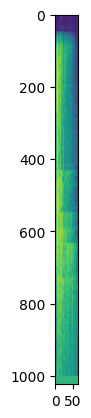

In [47]:
plt.imshow(fbank)